<a href="https://colab.research.google.com/github/javiervz/zipf/blob/master/zipf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A decentralized route to the origins of scaling in human language**

First, we create a population 

In [0]:
import networkx as nx
import numpy as np
import random
from tqdm import tqdm

In [0]:
# periodic grid graph of dim 2 and length L
def grid(L):
  G = nx.grid_2d_graph(L,L,periodic=True)
  return G

In [0]:
# complete graph of L**2 nodes
def complete(L):
  G = nx.complete_graph(L**2)
  return G

In [0]:
# matrix of ones and zeros (at random)
def lexical_matrix(n):
  M=np.array([0.5 if random.random()<1 else 0 for i in range(n**2)]).reshape(n,n)
  return M

In [0]:
# a population is defined by a (i) graph; and (ii) a dict of numpy matrices (representing vocabularies)
# L -> length of the grid 
# n -> number of words (rows of the lexical matrices)
# n -> number of meanings (columns of lexical matrices) (that is, only squared matrices)
def population(L,n):
  # grid (or complete) graph
  G=complete(L)
  nodes=G.nodes()
  lexical_dict={node:lexical_matrix(n) for node in nodes}
  return [G,lexical_dict]

Second, we define some functions on lexical interests

In [0]:
# this function allows us to consider the level of lexical compromise of agents
# matrix -> lexical matrix of the speaker
# meaning -> selected column
# speaker_interest -> if 0 the speaker selects the most ambiguous word; else, the speaker selects the least ambiguous word
def select_word(matrix,meaning,speaker_interest):
  # if the speaker does not known any word associated to the meaning
  if np.sum(matrix[:,meaning])==0:
    word=None#random.randint(0,len(matrix[:,meaning])-1)
  else:
    # sum of rows (number of meanings!) associated to the meaning (using the hadamard product)
    sum_rows=matrix.sum(axis=1)*matrix[:,meaning]
    # select the words with the greatest ambiguity if speaker==0
    if speaker_interest==0:
      ambiguity=max(sum_rows)
    else:
      ambiguity=min(sum_rows)#max(min(sum_rows),0)
    # indices associated to ambiguity
    indices_ambiguity=[index for index in range(len(sum_rows)) if sum_rows[index]==ambiguity]
    # select only one word!
    word=random.choice(indices_ambiguity)
  return word
  

In [0]:
# Now, we propose a simple speaker-hearer interaction
# speaker, hearer -> agent's locations (nodes!)
# lexical_dict -> dictionary of lexical metrices
# speaker_interest -> if 0 the speaker selects the most ambiguous word; else, the speaker selects the least ambiguous word
# meaning -> the topic of the conversation
def interaction(speaker,hearer,lexical_dict,speaker_interest,meaning):
  # lexical matrices
  hearer_matrix=lexical_dict[hearer]
  speaker_matrix=lexical_dict[speaker]
  # the speaker selects one word according to its lexical compromise
  r=random.randint(0,101)
  if random.random()>speaker_interest:#float(r)/100>speaker_interest:
    word=select_word(lexical_dict[speaker],meaning,0)
  else:
    word=select_word(lexical_dict[speaker],meaning,1)
    
  if word==None:
    word=random.randint(0,len(matrix[:,meaning])-1)
    speaker_matrix[word][meaning]=1
  # now, simple naming game rules
  # the hearer does not know the word (failure!)
  if hearer_matrix[word][meaning]==0:
    hearer_matrix[word][meaning]=1
  #lexical_dict[hearer]=hearer_matrix
  # else (success!)
  else:
    n=len(speaker_matrix)
    for i in range(n):
      # all words are set to 0
      hearer_matrix[i][meaning]=0
      speaker_matrix[i][meaning]=0
    # except one!
    hearer_matrix[word][meaning]=1
    speaker_matrix[word][meaning]=1
  # update dict of lexical matrices
  lexical_dict[hearer]=hearer_matrix
  lexical_dict[speaker]=speaker_matrix
  return lexical_dict
  
  
  
  

Third, preparing the simulation

In [0]:
# simulation of the agent-based model
# time -> number of interactions
# P -> population
def simulation(time,P,speaker_interest,n):
  # nodes 
  nodes=list(P[0].nodes())
  # lexical_matrices
  lexical_matrices=P[1]
  # loop!
  for i in tqdm(range(time)):
    # topic of the conversation
    meaning=random.randint(0,n-1)
    # speaker
    speaker=random.choice(nodes)
    # hearer
    hearer=random.choice(list(P[0].neighbors(speaker)))
    P[1]=interaction(speaker,hearer,P[1],speaker_interest,meaning)
  
  return P

In [0]:
## measuring the effective vocabulary
def effective_vocabulary(lexical_matrices,n): 
  a=0
  for node in lexical_matrices.keys():
    for i in range(n):
      if sum(lexical_matrices[node][i,:])>0:
        a+=1

  return a/float(len(lexical_matrices.keys())*n)

In [0]:
n=64
agents=4
time=2000000

In [29]:
speaker_interest=[k/float(20) for k in range(21)]
effective_vocabulary_dict={}
for interest in speaker_interest:
  P=population(agents,n)
  effective_vocabulary_dict[interest]=effective_vocabulary(simulation(time,P,interest,n)[1],n)

100%|██████████| 2000000/2000000 [01:37<00:00, 20542.42it/s]


In [30]:
effective_vocabulary_dict

{0.0: 0.03125,
 0.05: 0.048828125,
 0.1: 0.072265625,
 0.15: 0.109375,
 0.2: 0.1396484375,
 0.25: 0.177734375,
 0.3: 0.2021484375,
 0.35: 0.2646484375,
 0.4: 0.30078125,
 0.45: 0.3779296875,
 0.5: 0.4365234375,
 0.55: 0.5224609375,
 0.6: 0.5927734375,
 0.65: 0.720703125,
 0.7: 0.8193359375,
 0.75: 0.9228515625,
 0.8: 0.962890625,
 0.85: 0.9892578125,
 0.9: 0.9990234375,
 0.95: 0.99609375,
 1.0: 0.9921875}

In [31]:


from google.colab import drive
drive.mount('/content/drive',force_remount=True)



Mounted at /content/drive


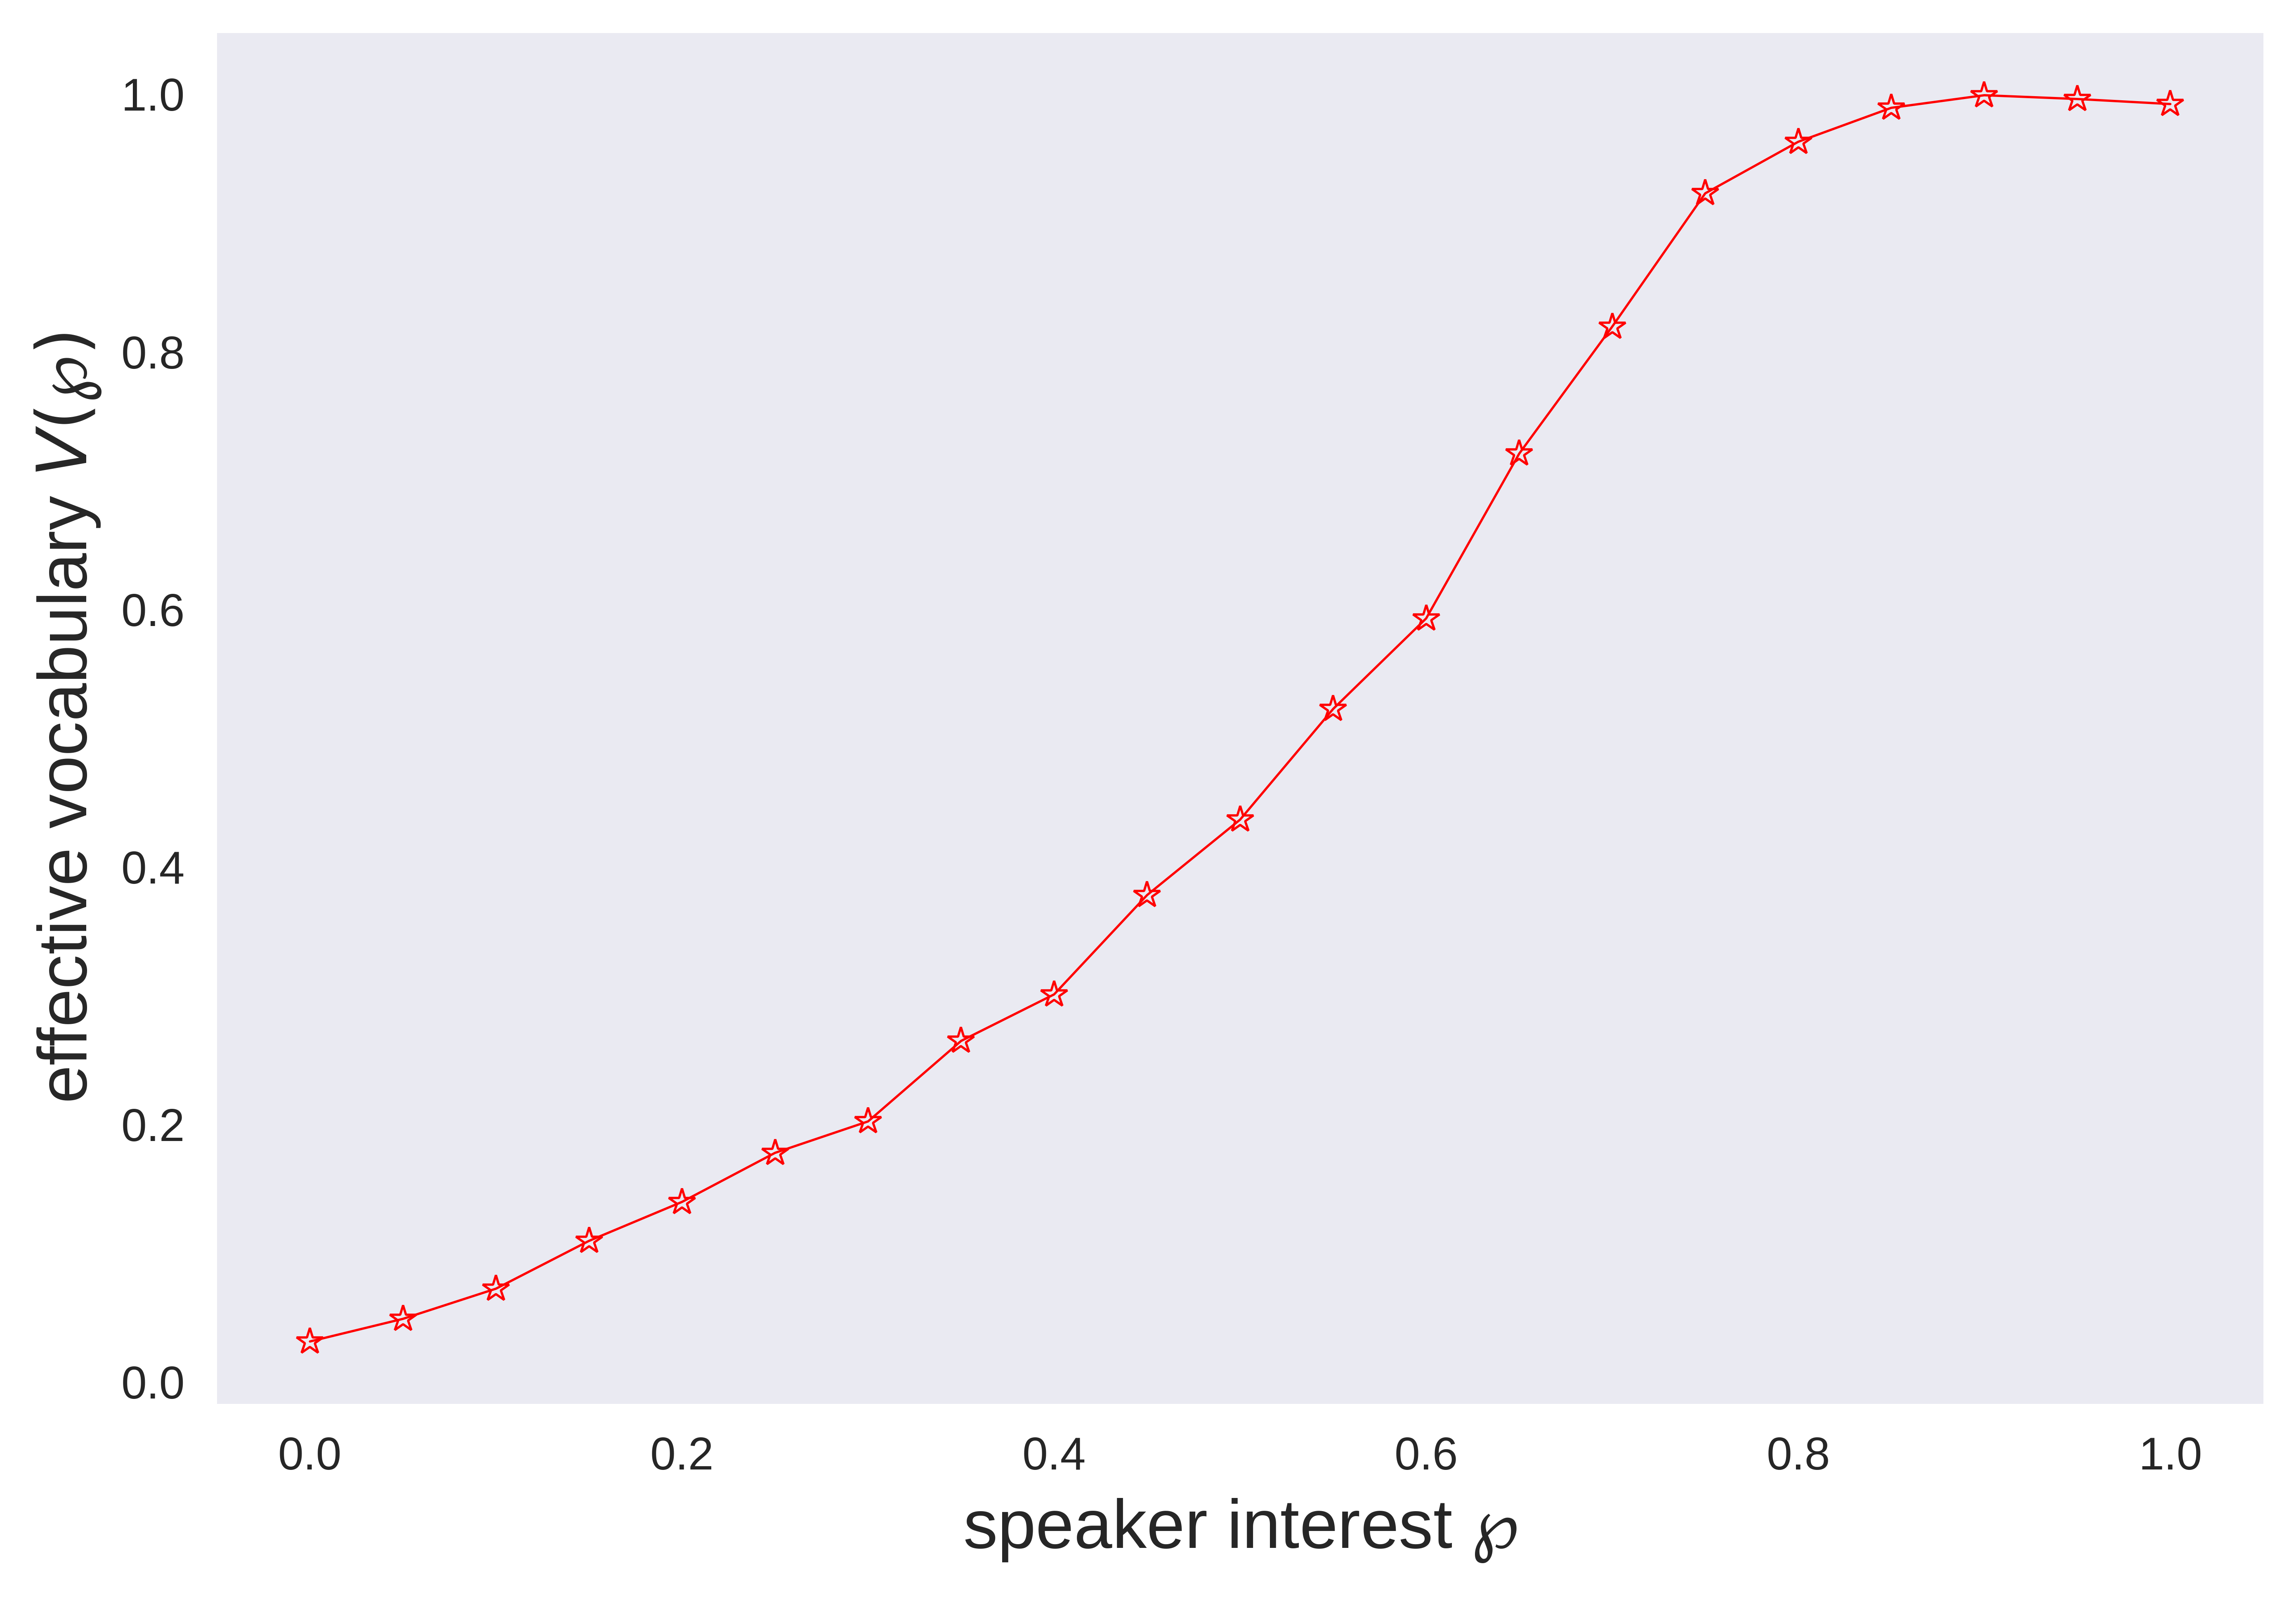

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=800)
X=list(effective_vocabulary_dict.keys())
Y=list(effective_vocabulary_dict.values())

ax.plot(X,Y, color='r',marker='*',markersize=6,fillstyle='none',markeredgewidth=0.5,clip_on=True,linewidth=0.5)

plt.grid(False)
#plt.legend(loc='best')
plt.ylabel(r'effective vocabulary $V(\wp)$',fontsize=15)
plt.xlabel(r'speaker interest $\wp$',fontsize=15)
plt.rcParams.update({'font.size': 10})
plt.savefig('/content/drive/My Drive/zipf/effective_vocabulary.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=800)
plt.show()

In [0]:
#initial_conditions=[(time,population(agents,64),k/float(4),64) for k in range(5)]

In [0]:
#from itertools import starmap                                                     
#map_simulation=list(starmap(simulation, initial_conditions))